In [1]:
import showdown
import agent
import asyncio
import torch
import json
from datetime import datetime
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
async def training_loop(agent, showdown, numBattles=5000):
    agentWins = 0
    agentWinsTotal = 0
    agentLosses = 0
    cumulativeRewards = 0
    plotX = []
    plotY = []
    
    for battle in range(numBattles):
        battleReward = -10
        battleProgress = []
        
        
        await showdown.restart()
        battleDone = False
        totalReward = 0
        
        while not battleDone:
            state = showdown.getState()
            
            validActions = showdown.getValidActions()
            action = agent.act(state, validActions)
            nextState, reward, battleDone, winner = await showdown.executeAction(action)
            print(f"Action: {action}, Reward: {reward}")
            
            battleProgress.append((state, action, reward, nextState, battleDone))
            agent.replay()
            totalReward += reward
            cumulativeRewards += reward
            
            if battleDone:
                print(f"Battle {battle} done. Total reward: {totalReward}")
                if winner == 1:
                    agentWins += 1 
                    battleReward = 20
                    
                    # Store winning battles more.
                    for i in range(10):
                        battleProgress.append((nextState, action, battleReward, nextState, battleDone))
                else:
                    agentLosses += 1
        
        thisBattleReward = 0
        # Once the battle's done...
        for i, (state, action, reward, nextState, done) in enumerate(battleProgress):
            # Adjust the reward based on how the battle went.
            adjustedReward = reward + (battleReward / (len(battleProgress)))
            thisBattleReward += adjustedReward
            agent.remember(state, action, adjustedReward, nextState, done)
            
        plotX.append(battle)
        plotY.append(thisBattleReward)
        print(plotY)
        
        agent.replay()        
        
        if battle % 10 == 0 and battle > 0:
            clear_output(wait=True)
            
            timestamp = datetime.now().strftime("%Y_%m%d-%p%I_%M_%S")
            # Save output to file
            with open(f"data/logs/outputs/output-{battle}-{timestamp}.txt", "w") as file:
                file.write(f"Current Stats: \n Wins This Cycle: {agentWins} \n Total Wins: {agentWinsTotal } \n Losses: {agentLosses} \n Cumulative Rewards: {cumulativeRewards} \n Battles: {battle} \n Epsilon: {agent.epsilon}")
             
            print(f"Cleared Output! Current Stats: \n Wins This Cycle: {agentWins} \n Total Wins: {agentWinsTotal } \n Losses: {agentLosses} \n Cumulative Rewards: {cumulativeRewards} \n Battles: {battle} \n Epsilon: {agent.epsilon}")
        if battle % 50 == 0 and battle > 0:
            agentWinsTotal += agentWins
            
            # Reset epsilon according to win ratio
            winRatio = agentWins/50
            
            if winRatio < 0.2:
                
                # Reset Epsilon
                agent.epsilon = max(agent.epsilon, 0.3)
            
            agentWins = 0
            
            # Save model and memory
            agent.saveModel(f"data/models/model_{battle}.pt")
            agent.saveMemory(f"data/memory/memory_{battle}.json")
            # X = Battles, Y = Rewards
            plt.plot(plotX, plotY)
            plt.xlabel('Battles')
            plt.ylabel('Rewards')
            plt.title('Learning Curve')
            plt.savefig(f"data/logs/plots/plot-{battle}-{timestamp}.png")
            plt.show()
            f = open(f"data/stats/{battle}.json", "w")
            f.write(json.dumps({"wins": agentWins, "losses": agentLosses, "rewards": cumulativeRewards}))
            f.close()

Cleared Output! Current Stats: 
 Wins This Cycle: 0 
 Total Wins: 0 
 Losses: 51 
 Cumulative Rewards: -89.452158664571 
 Battles: 50 
 Epsilon: 0.30863748084864606


FileNotFoundError: [Errno 2] No such file or directory: 'data/plots/plot-50-2025_0325-PM06_13_17.png'

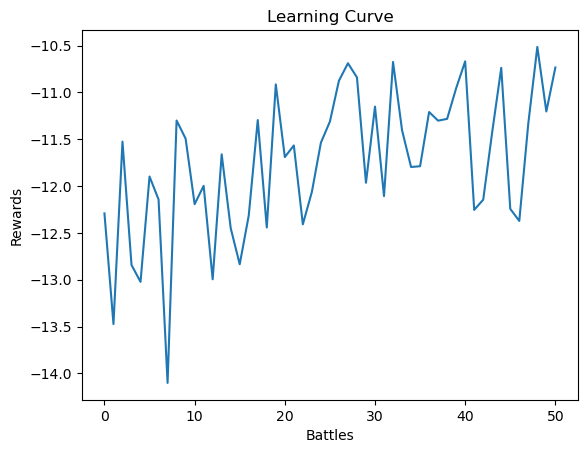

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stateSize = 671

possibleActions = json.load(open("data/possible_actions.json", "r"))
actionSize = len(possibleActions)

newAgent = agent.Agent(stateSize, actionSize, device, possibleActions)
#newAgent.loadModel("data/models/model_450.pt")
#newAgent.loadMemory("data/memory/memory_450.json")

showdown = showdown.Showdown("https://play.pokemonshowdown.com/action.php", "PoryAI-0", "password", "ws://localhost:8000/showdown/websocket", "gen9randombattle")

await showdown.connectNoSecurity()
await training_loop(newAgent, showdown, 10000)